In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
pip -q install transformers
pip -q install datasets

# remove the directory if necessary
# rm -rf "/content/gdrive/MyDrive/6864_hw4/"

mkdir "/content/drive/My Drive/NLP/"
cd "/content/drive/My Drive/NLP/"

mkdir: cannot create directory ‘/content/drive/My Drive/NLP/’: File exists


In [3]:
import numpy as np
import pandas as pd
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
project_path = '/content/drive/My Drive/NLP/'

from datasets import load_dataset

dataset = load_dataset('liar')
dataset
# print([a for a in dataset['train'] if a['label'] == 5][0])


Using custom data configuration default


Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [5]:
def bin_labels(dataset):
  mapping = {
      0: 'false',
      1: 'half-true',
      2: 'mostly-true',
      3: 'true',
      4: 'barely-true',
      5: 'pants-fire'
  }
  texts = np.array(dataset['statement'])
  labels = np.array(dataset['label'])
  true = labels == 3
  mostly_true = labels == 2
  pos_labels = np.logical_or(true, mostly_true)
  labels = np.where(pos_labels, 1, 0)

  new_dataset = pd.DataFrame()
  new_dataset['text'] = texts
  new_dataset['label'] = labels
  return new_dataset

data_train = bin_labels(dataset['train'])
data_val = bin_labels(dataset['validation'])
data_test = bin_labels(dataset['test'])
  
  

In [6]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained('roberta-base')
tokenizer('hello world')

{'input_ids': [0, 42891, 232, 2], 'attention_mask': [1, 1, 1, 1]}

In [7]:
import torch.nn as nn

class FakeNewsClassifier(nn.Module):
  def __init__(self, lm, dropout=0.2):
    super(FakeNewsClassifier, self).__init__()
    self.lm = lm
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(lm.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask=None):
    lm_output = self.lm(input_ids, attention_mask)
    pooled = lm_output.pooler_output
    pooled = self.dropout(pooled)
    lin_output = self.linear(pooled)
    pred = self.sigmoid(lin_output)
    return pred
  


In [8]:
roberta = transformers.AutoModel.from_pretrained('roberta-base')
model = FakeNewsClassifier(roberta)
model = model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def tokenize_batch_farn(batch):
  x = list(batch['text'])
  y = np.array(batch['label'])
  
  x_encode = tokenizer.batch_encode_plus(
      x,
      max_length=512,
      truncation=True,
      padding='longest',
      return_attention_mask=True,
      return_tensors='pt'
  )
  input_ids = x_encode['input_ids'].cuda()
  input_mask = x_encode['attention_mask'].cuda()

  return input_ids, input_mask, y

In [10]:

training_size = len(data_train)
validation_size = len(data_val)
testing_size = len(data_test)

# data_train = dataset[:training_size]
# data_val = dataset[training_size:training_size+validation_size]
# data_test = dataset[training_size+validation_size:]

print(len(data_train))
print(data_train['label'].sum() / len(data_train))
print(len(data_val))
print(data_val['label'].sum() / len(data_val))
print(len(data_test))
print(data_test['label'].sum() / len(data_test))


10269
0.3553413185315026
1284
0.32710280373831774
1283
0.35853468433359315


In [11]:
def decode(pred):
  decoded = torch.where(pred >= 0.5, 1, 0)
  return decoded

def get_acc(preds, labels):
  decoded = decode(preds).to(dtype=torch.float32)
  acc = torch.where(decoded == labels, 1, 0)
  return acc.sum()


Loss: 0.49499163031578064
Val acc: 0.6417445482866043
Loss: 0.16939719021320343
Val acc: 0.6394080996884736
Loss: 0.42951205372810364
Val acc: 0.6191588785046729
Loss: 0.6907695531845093
Val acc: 0.6627725856697819
Loss: 0.28465986251831055
Val acc: 0.6728971962616822
Loss: 0.6258305907249451
Val acc: 0.6728971962616822
Loss: 0.3914782702922821
Val acc: 0.6658878504672897
Loss: 0.15763406455516815
Val acc: 0.6900311526479751
Loss: 0.3799644112586975
Val acc: 0.5319314641744548
Loss: 0.4002774953842163
Val acc: 0.6876947040498442
Loss: 0.20454701781272888
Val acc: 0.6728971962616822
Loss: 0.7002902030944824
Val acc: 0.690809968847352
Loss: 0.354655385017395
Val acc: 0.6830218068535826
Loss: 0.1570671796798706
Val acc: 0.692367601246106
Loss: 0.2999120354652405
Val acc: 0.6269470404984424
Loss: 0.17758016288280487
Val acc: 0.6674454828660437
Loss: 0.259010374546051
Val acc: 0.67601246105919
Loss: 0.8825126886367798
Val acc: 0.6876947040498442
Loss: 0.4384714663028717
Val acc: 0.659657320

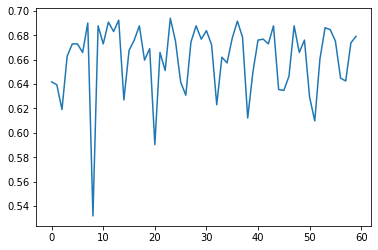

In [ ]:

import matplotlib.pyplot as plt

num_epochs = 10
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 16
warmup_rate = 0.05

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

loss_fn = nn.BCELoss()

model.train()

val_accuracies = []
for _ in range(num_epochs):
  for i in range(0, len(data_train), batch_size):
    batch = data_train[i : i + batch_size]
    input_ids, input_mask, labels = tokenize_batch_farn(batch)
    labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()

    model.zero_grad()
    predictions = model(input_ids, input_mask)
    predictions.to(torch.float32)

    loss = loss_fn(predictions, labels)
    loss.backward()

    ext_optim.step()

    if i % 1000 == 0:
      total_val_acc = 0
      val_batch_size = 16
      for i in range(0, len(data_val), val_batch_size):
        input_ids, input_mask, labels = tokenize_batch_farn(data_val[i : i+val_batch_size])
        labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()
        preds = model.forward(input_ids, input_mask)
        decoded = decode(preds).to(dtype=torch.float32)
        acc = get_acc(decoded, labels)
        total_val_acc += acc
      total_val_acc = int(total_val_acc) / len(data_val)
      val_accuracies.append(total_val_acc)

      print("Loss: {}".format(loss))
      print("Val acc: {}".format(total_val_acc))

plt.plot(val_accuracies)
plt.show()

torch.save(model.state_dict(), project_path+'roberta/model_embed_liar.pt')




In [13]:
model.load_state_dict(torch.load(project_path + "roberta/model_embed_liar.pt"))

<All keys matched successfully>

In [16]:
# def decode(pred):
#   decoded = torch.where(pred >= 0.5, 1, 0)
#   return decoded

test_sample = data_test

results = []
labels_ = []
total_acc = 0
test_batch_size = 1
for i in range(0, len(test_sample), test_batch_size):

  input_ids, input_mask, labels = tokenize_batch_farn(test_sample[i : i+test_batch_size])
  labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()

  preds = model.forward(input_ids, input_mask)
  decoded = decode(preds).to(dtype=torch.float32)

  results.append(decoded)
  labels_.append(labels)
  acc = torch.where(decoded == labels, 1, 0)
  total_acc += acc.sum()

print(int(total_acc) / len(test_sample))


0.5720966484801248


In [17]:

results = torch.cat(results).cpu()

labels = torch.cat(labels_).cpu()

print(results.shape, labels.shape)
results = results.reshape(-1)
labels = labels.reshape(-1)
print(results.shape, labels.shape)

from sklearn.metrics import precision_score, recall_score, f1_score

# accuracy = (results == labels).sum() / len(labels)

prec = precision_score(labels, results)
recall = recall_score(labels, results)
f1 = f1_score(labels, results)

print(acc, prec, recall, f1)

# true_pos = torch.logical_and([results, labels])
# false_pos = torch.logical_and([results, torch.logical_not(labels)])
# false_neg = torch.logical_and([labels, torch.logical_not(results)])

# precision = true_pos.sum() / (true_pos.sum() + false_pos.sum())
# recall = true_pos.sum() / (true_pos.sum() + false_neg.sum())

torch.Size([1283, 1]) torch.Size([1283, 1])
torch.Size([1283]) torch.Size([1283])
tensor([[0]], device='cuda:0') 0.434654919236417 0.6434782608695652 0.518843120070114
